In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from fastai.tabular import *
import scipy.signal as s

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
path.ls()

[PosixPath('data/LFP_Prediction/lfp_labels.csv'),
 PosixPath('data/LFP_Prediction/model_LFP_and_FR.csv'),
 PosixPath('data/LFP_Prediction/LFP_y_hilb'),
 PosixPath('data/LFP_Prediction/model_fr_lfp.csv')]

In [5]:
labels = pd.read_csv(path/"lfp_labels.csv", index_col = "start")

In [6]:
df = pd.read_csv(path/"model_fr_lfp.csv", header = None)

In [7]:
df = df.iloc[:len(labels)]

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3.2895,1.40650,1.2063,1.40850,0.00000,0.0000,1.1641,1.7817,1.6214,0.0000,0.000,6.135,12.291,9.4093,7.5567,3.08700,0.318140,0.48574
1,0.0000,3.75060,1.3786,2.03440,0.76923,0.0000,1.1641,1.3363,1.2161,3.8685,0.000,12.270,15.642,15.6820,5.0378,-2.18430,0.021294,0.62928
2,3.2895,1.87530,1.3786,2.03440,3.07690,0.0000,4.6566,1.7817,1.6214,1.9342,0.000,10.736,11.173,10.4550,5.0378,-2.50610,-0.242560,0.58209
3,0.0000,0.93765,1.2063,0.93897,2.30770,0.0000,3.4924,1.7817,2.0268,1.9342,0.000,12.270,16.760,10.9780,7.5567,0.30809,-0.430020,0.60523
4,3.2895,0.93765,1.2063,1.40850,1.53850,8.1967,1.1641,1.3363,2.0268,1.9342,18.519,12.270,13.408,11.5000,0.0000,1.04120,-0.526600,0.56868


In [18]:
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [19]:
class TimeWindowList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, num_forward, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_forward)], **kwargs)
        self.num_forward = num_forward
        self.num_back = num_back
        self.copy_new.append("num_back")
        self.copy_new.append("num_forward")
        
    def get(self, i):
        return TimeWindow(self.its[i : self.num_back + i, :-1])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_forward
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        #return torch.Tensor(int(1 in self.its[i + self.num_back: i + self.num_back + self.num_forward, 3]))[None]
        return int(self.its[i + num_back, -1])

In [20]:
num_back = 100
num_forward = 10

In [433]:
data_input = np.stack([df[i] for i in range(16)] + [labels.P_or_T_above], axis = -1)

In [434]:
#Replicating each true sample once
index = 0
while(index < len(data_input)):
    if data_input[index][-1] == 1:
        data_input = np.insert(data_input, index, data_input[index], axis = 0)
        index += 1
    index += 1

In [435]:
data_input.shape

(58021, 17)

In [187]:
data = (TimeWindowList(data_input, num_back, num_forward)
                .split_by_idx(range(40000, len(data_input) - num_back - num_forward))
                .label_from_func(lambda x: x)
                .databunch(bs = 64))

In [188]:
data

DataBunch;

Train: LabelList (39890 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (17801 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Test: None

In [216]:
class PaperModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (8, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (6, 1), stride = (2, 1), padding = (2, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
            nn.Conv1d(1, 1, kernel_size = (5, num_features), padding = (2, 7)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        self.lins = nn.Sequential(
            nn.Linear(num_features * 25 - 25, 25),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.Linear(25, out_size),
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [217]:
def isNan(num):
    return num != num

In [218]:
def true_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [219]:
def false_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [220]:
learn = Learner(data, PaperModel(2, 16), loss_func = torch.nn.modules.loss.CrossEntropyLoss(weight = torch.Tensor([1, 4]).cuda()), 
                metrics = [accuracy, true_acc, false_acc], wd = 1e-1)

In [221]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-01
Min loss divided by 10: 3.02E-02


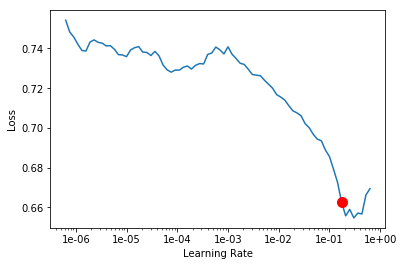

In [222]:
learn.recorder.plot(skip_end = 10, suggestion=True)

In [223]:
lr = 1e-3

In [224]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,true_acc,false_acc,time
0,0.543743,0.629610,0.525139,0.472580,0.276620,00:11
1,0.215998,0.145094,0.966856,0.436647,0.866449,00:11
2,0.150846,0.132688,0.972249,0.441716,0.876654,00:11
3,0.176936,0.123750,0.975788,0.440193,0.885457,00:11
4,0.155144,0.118097,0.976911,0.444447,0.887115,00:11
5,0.168297,0.114601,0.977529,0.448103,0.886269,00:11
6,0.142131,0.110125,0.978934,0.446989,0.889198,00:11
7,0.148235,0.110186,0.978934,0.445447,0.890569,00:11
8,0.160584,0.106225,0.979215,0.450052,0.888843,00:11
9,0.149608,0.108673,0.979271,0.450379,0.888787,00:11


In [436]:
learn.save("P_or_T_above")

## Results

In [225]:
interp = ClassificationInterpretation.from_learner(learn)

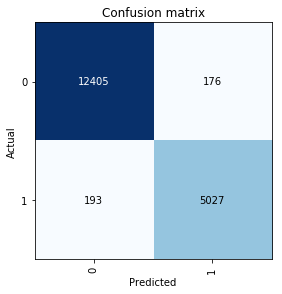

In [226]:
interp.plot_confusion_matrix()

In [437]:
confusion = interp.confusion_matrix()

In [439]:
#Above accuracy
confusion[1][1] / confusion[1].sum()

0.9630268199233717

In [441]:
#Not above accuracy
confusion[0][0] / confusion[0].sum()

0.986010650981639

## Explainability

In [228]:
from fastai.callbacks.hooks import *

In [229]:
m = learn.model.eval()

In [230]:
m

PaperModel(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(8, 1), stride=(2, 1), padding=(3, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25)
    (4): Conv2d(64, 128, kernel_size=(6, 1), stride=(2, 1), padding=(2, 0))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
    (8): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4)
    (12): Conv1d(1, 1, kernel_size=(5, 16), stride=(1,), padding=(2, 7))
    (13): ReLU()
    (14): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.4)
  )
  (lins): Sequential(
    (0): Linear(in_features=375, out_features=25, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=T

In [231]:
def hooked_backward(cat, xb, layer):
    with hook_output(m.convs[layer]) as hook_a: 
        with hook_output(m.convs[layer], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [381]:
def get_grad_cam(data, item, layer, m):
    y = item[1]
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(y, xb, layer)
    acts = hook_a.stored[0].cpu()
    
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    
    return  np.transpose((acts*grad_chan[...,None,None]).mean(0))

In [382]:
def percentize(features):
    for i in range(len(features)):
        features[i] = np.array([features[i][j] / features[i].max() for j in range(100)])
        
    return features

In [392]:
relu = nn.ReLU()

In [410]:
item = data.valid_ds[224]

In [411]:
g = get_grad_cam(data, item, 5, m)

In [412]:
g = relu(g)

In [413]:
g = np.repeat(g, 4, 1)

In [414]:
g = percentize(np.array(g))

In [415]:
xs = np.array(item[0].data[0])

In [416]:
xs.shape

(100, 16)

In [417]:
xs = np.transpose(xs)

In [418]:
xs = percentize(xs)

Data in heatmap form (This is a sample that had a peak/trough above)

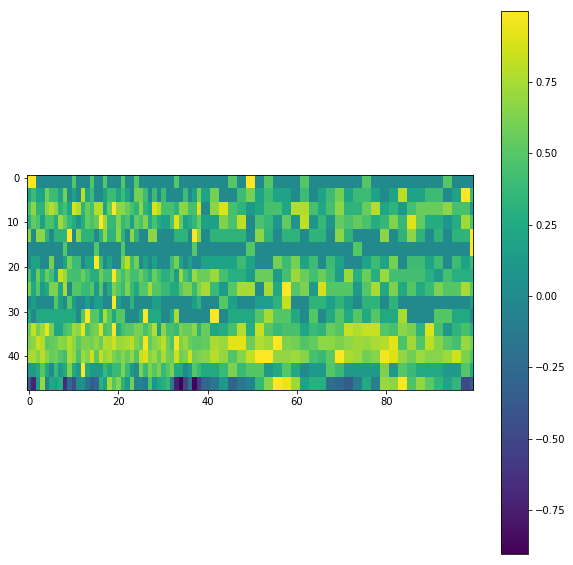

In [420]:
plt.figure(figsize = (10, 10))
plt.imshow(np.repeat(xs, 3, 0))
plt.colorbar()
plt.show()

GradCam results of the same sample as above

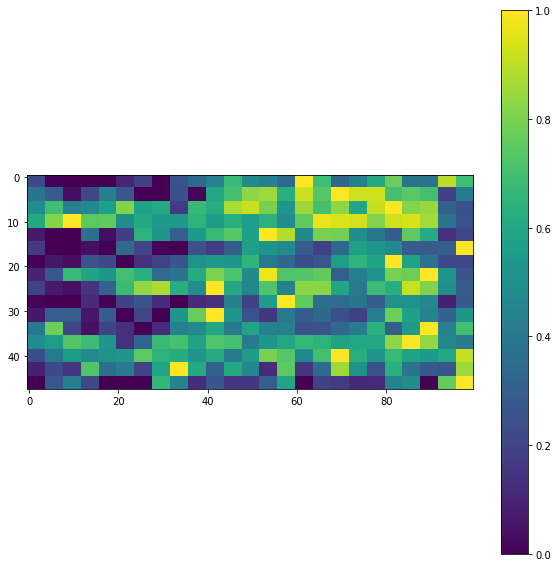

In [442]:
plt.figure(figsize = (10, 10))
plt.imshow(np.repeat(g, 3, 0))
plt.colorbar()
plt.show()